Window_Operation_Analysis_Version 3

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns

/Users/xinyuyangren/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


# Status overview & Dataframe Preparation

In [303]:
Behav = pd.read_csv("/Users/xinyuyangren/Documents/TU:e_Year2/Thesis"
                    "/Aramis_Data_Warehouse/Behavior_Study/1000_Behav.csv")

#for 3,5,7,8,9 to rename br1 to br3

#Behav.rename(columns={'t_br1':'t_br3','rh_br1':'rh_br3','co2_br1':'co2_br3','con_br1':'con_br3','wc_br1':'wc_br3'}, inplace=True)

In [304]:
# Remap string t and f to 1 and 0, for the consequent classifying

def remap(x):
    if x == 't':
        x = 1
    else:
        x = 0
    return x

for col in ['wc_lr', 'wc_kitchen', 'wc_br3', 'wc_br2', 'wc_attic']:
    w = Behav[col].apply(remap)
    Behav[col] = w

In [305]:
#Drop rows with missing value
Behav = Behav.dropna()

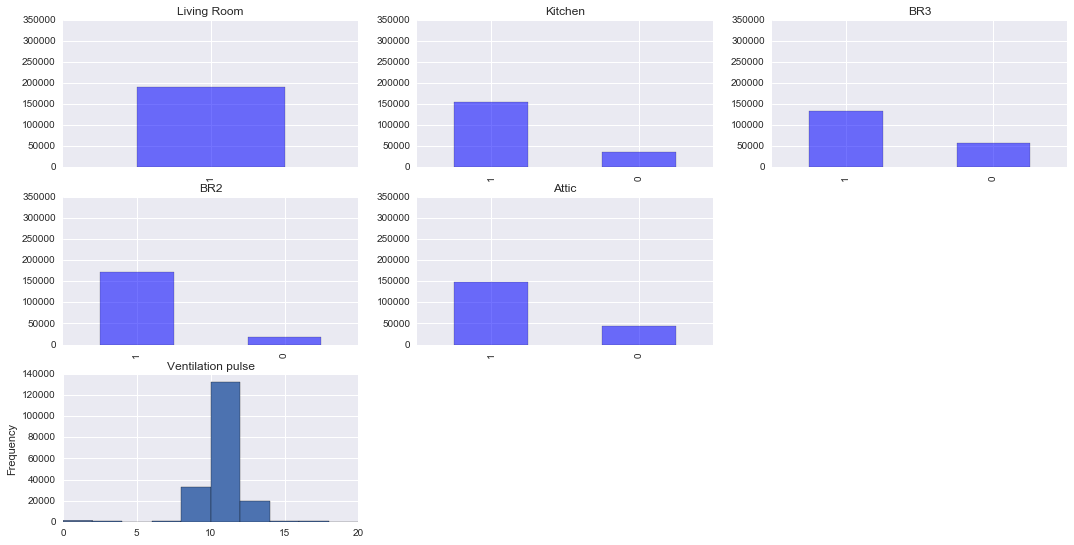

In [306]:
# some statistics
# specifies the parameters of our graphs
fig = plt.figure(figsize=(18,9), dpi=1600) 
alpha_bar_chart = 0.55

# lets us plot many diffrent shaped graphs together 
ax1 = plt.subplot2grid((3,3),(0,0))
# plots a bar graph of those who surived vs those who did not.               
Behav.wc_lr.value_counts().plot(kind='bar', alpha=alpha_bar_chart)
plt.title('Living Room')
plt.ylim(0,350000)

# lets us plot many diffrent shaped graphs together 
ax2 = plt.subplot2grid((3,3),(0,1))
# plots a bar graph of those who surived vs those who did not.               
Behav.wc_kitchen.value_counts().plot(kind='bar', alpha=alpha_bar_chart)
plt.title('Kitchen')
plt.ylim(0,350000)

# lets us plot many diffrent shaped graphs together 
ax3 = plt.subplot2grid((3,3),(0,2))
# plots a bar graph of those who surived vs those who did not.               
Behav.wc_br3.value_counts().plot(kind='bar', alpha=alpha_bar_chart)
plt.title('BR3')
plt.ylim(0,350000)

# lets us plot many diffrent shaped graphs together 
ax4 = plt.subplot2grid((3,3),(1,0))
# plots a bar graph of those who surived vs those who did not.               
Behav.wc_br2.value_counts().plot(kind='bar', alpha=alpha_bar_chart)
plt.title('BR2')
plt.ylim(0,350000)

# lets us plot many diffrent shaped graphs together 
ax5 = plt.subplot2grid((3,3),(1,1))
# plots a bar graph of those who surived vs those who did not.               
Behav.wc_attic.value_counts().plot(kind='bar', alpha=alpha_bar_chart)
plt.title('Attic')
plt.ylim(0,350000)

ax5 = plt.subplot2grid((3,3),(2,0))
# plots a bar graph of those who surived vs those who did not.               
Behav.pulse_channel_ventilation_unit.plot(kind='hist')
plt.title('Ventilation pulse')

In [307]:
#generate month/hour attribute from datetime string

Behav.dt = pd.to_datetime(Behav.dt)
t = pd.DatetimeIndex(Behav.dt)
hr = t.hour
Behav['HourOfDay'] = hr
month = t.month
Behav['Month'] = month
dt = Behav.pop('dt')

In [308]:
# to build the tree in rapid miner
#copy = Behav.ix[:,['t_br3','HourOfDay','Month','avg_t','wc_br3']]
#copy.to_csv(path_or_buf='/Users/xinyuyangren/Desktop/forTree/copy1.csv',index = False) 

Run Above here to pre-process the dataset

# Bedroom 3 Window Operation: Motivation Study

In [309]:
wc = Behav.pop('wc_br3')
Behav = Behav.ix[:,['t_br3','HourOfDay','Month','avg_t']]

In [310]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

In [311]:
rf_w = RandomForestClassifier(n_estimators=500,n_jobs=-1,oob_score=True)

In [312]:
rf_w.fit(Behav,wc)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [313]:
#out-of-bag score, which is equivalent to test set accuracy
print rf_w.oob_score_

0.981982783432


t_br3        0.274761
HourOfDay    0.264871
Month        0.100509
avg_t        0.359860
dtype: float64


/Users/xinyuyangren/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: sort is deprecated, use sort_values(inplace=True) for for INPLACE sorting


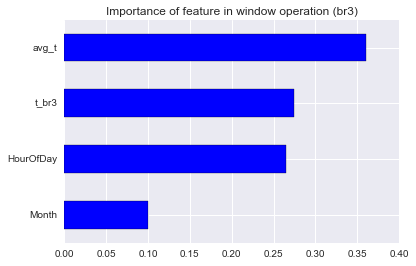

In [314]:
# This feature_importances implies how imformative certain attribute is in the classifying process
# (By calculating the error reduction with each attribute)

feature_importances_w = pd.Series(rf_w.feature_importances_,index = Behav.columns)
print feature_importances_w
feature_importances_w.sort(inplace = True)
feature_importances_w.plot(kind = 'barh',title = 'Importance of feature in window operation (br3)')

0.634620579771 0.365379420229


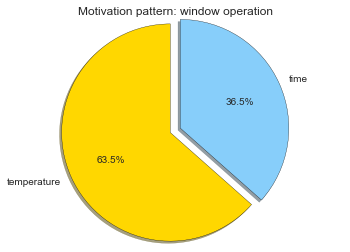

In [315]:
# Motivation breakdown

time_w = feature_importances_w.Month + feature_importances_w.HourOfDay

temp_w = feature_importances_w.t_br3 + feature_importances_w.avg_t

print temp_w, time_w

# The slices will be ordered and plotted counter-clockwise.
labels = 'temperature', 'time'
sizes = [temp_w, time_w]
colors = ['gold', 'lightskyblue']
explode = (0, 0.1) # only "explode" the 2nd slice

plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=90)
# Set aspect ratio to be equal so that pie is drawn as a circle.
plt.axis('equal')

plt.title('Motivation pattern: window operation')
plt.show()

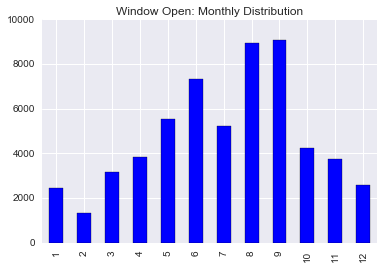

In [316]:
openidx = wc[wc == 0].index
openmonth = Behav['Month'][openidx]
openmonth.value_counts(sort=False).plot(kind = 'bar')
plt.title('Window Open: Monthly Distribution')

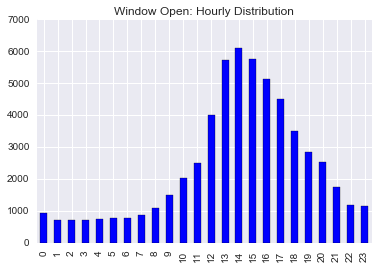

In [317]:
openhour = Behav['HourOfDay'][openidx]
openhour.value_counts(sort=False).plot(kind = 'bar')
plt.title('Window Open: Hourly Distribution')

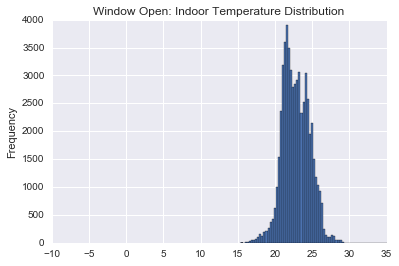

In [318]:
opentemp = Behav['t_br3'][openidx]
opentemp.plot(kind = 'hist',bins = 100,xlim = (-10,35))
plt.title('Window Open: Indoor Temperature Distribution')

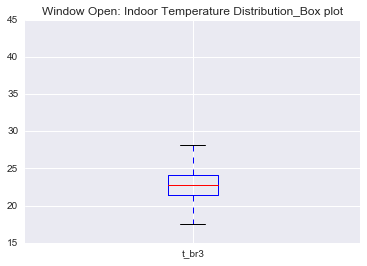

In [319]:
opentemp.plot(kind = 'box')
plt.title('Window Open: Indoor Temperature Distribution_Box plot')

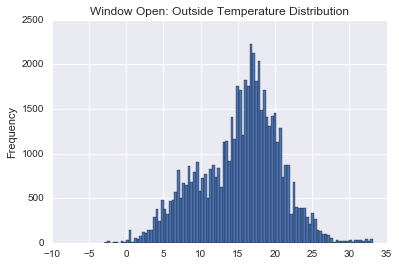

In [320]:
openouttemp = Behav['avg_t'][openidx]
openouttemp.plot(kind = 'hist',bins = 100,xlim = (-10,35))
plt.title('Window Open: Outside Temperature Distribution')

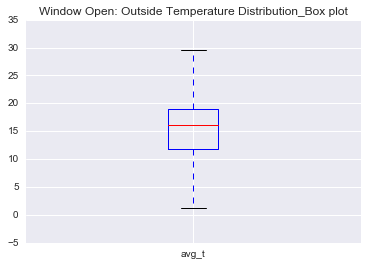

In [321]:
openouttemp.plot(kind = 'box')
plt.title('Window Open: Outside Temperature Distribution_Box plot')

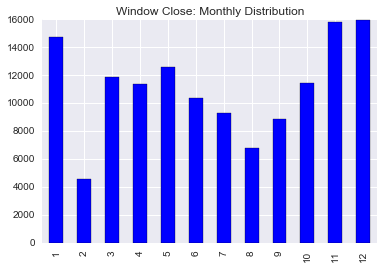

In [322]:
closeidx = wc[wc == 1].index
closemonth = Behav['Month'][closeidx]
closemonth.value_counts(sort=False).plot(kind = 'bar')
plt.title('Window Close: Monthly Distribution')

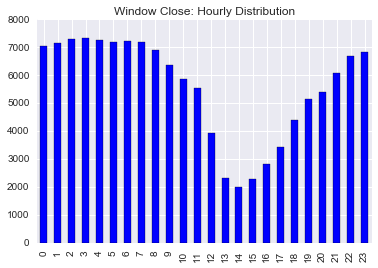

In [323]:
closehour = Behav['HourOfDay'][closeidx]
closehour.value_counts(sort=False).plot(kind = 'bar')
plt.title('Window Close: Hourly Distribution')

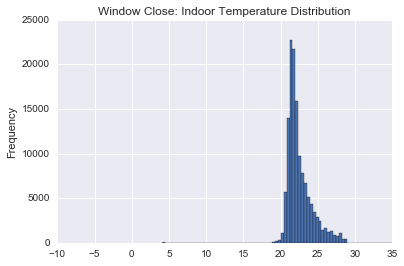

In [324]:
closetemp = Behav['t_br3'][closeidx]
closetemp.plot(kind = 'hist',bins = 100,xlim = (-10,35))
plt.title('Window Close: Indoor Temperature Distribution')

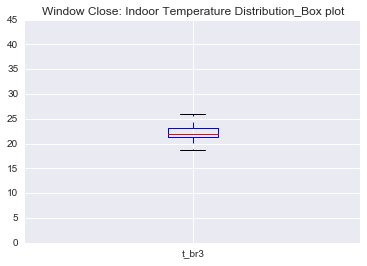

In [325]:
closetemp.plot(kind = 'box')
plt.title('Window Close: Indoor Temperature Distribution_Box plot')

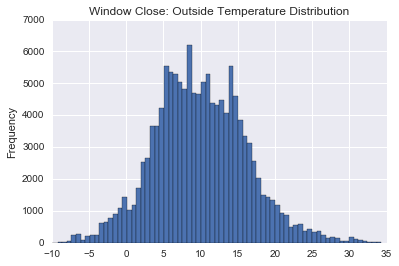

In [326]:
closeouttemp = Behav['avg_t'][closeidx]
closeouttemp.plot(kind = 'hist',bins = 200,xlim = (-10,35))
plt.title('Window Close: Outside Temperature Distribution')

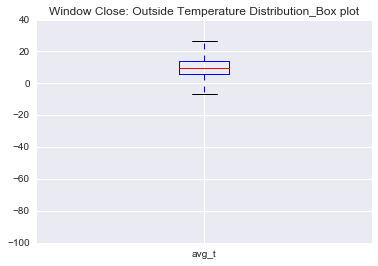

In [327]:
closeouttemp.plot(kind = 'box')
plt.title('Window Close: Outside Temperature Distribution_Box plot')